In [ ]:
import json
import os
import shutil
import subprocess
import ete3
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from Bio import AlignIO, Phylo, SeqIO
from ete3 import Tree
from pastml import acr

In [323]:
input_sequences = "ADA1_curated_022525_under420.fa"
outgroup_sequences = "outgroup_names.txt"  # outgroups for tree
outgroup_names = ['A0A661W0I8_Chloroflexota_bacterium','A0A7Y5TQX5_Gemmatimonadaceae_bacterium']

run_folder = "ADA1_ASR/"  # folder to store all outputs and intermediate files

## Trim sequence names to 10 character max

In [33]:
# Move original sequences into run folder
os.makedirs(run_folder)

# copy sequences into run folder
if os.path.abspath(input_sequences) != os.path.abspath(run_folder):
    shutil.copy2(input_sequences, run_folder)
    input_sequences = run_folder + os.path.basename(input_sequences)
    print(f"Input sequences copied to '{input_sequences}'.")

Input sequences copied to 'ADA1_ASR/ADA1_curated_022525_under420.fa'.


In [34]:
# Recode them to 10 char max (PAML is limited to phylip format with 10 char max)
recoded_sequences = input_sequences.split(".")[0] + "_recoded.fa"
recoding_dict_file = run_folder + "recoding_dict.txt"

counter = 0
with open(recoding_dict_file, "w") as dict_file:
    with open(recoded_sequences, "w") as seq_file:
        for record in SeqIO.parse(input_sequences, "fasta"):
            seq_name = "seq" + str(counter)
            seq_file.write(">" + seq_name + "\n" + str(record.seq) + "\n")
            dict_file.write(seq_name + "\t" + record.id + "\n")
            counter += 1

## Build alignment with MAFFT

In [35]:
mafft_out = recoded_sequences.split(".")[0] + "_mafft.fa"

mafft_cmd = f"mafft --localpair {recoded_sequences} > {mafft_out}"

try:
    result = subprocess.run(mafft_cmd, shell=True, check=True, text=True, capture_output=True)
    print(f"Alignment file {mafft_out} generated")
except subprocess.CalledProcessError as e:
    print("Error occurred during execution")
    print(e.stderr)

# convert to Phylip sequential format for PAML
mafft_phylip = mafft_out.split(".")[0] + ".ph"

alignment = AlignIO.read(mafft_out, "fasta")
AlignIO.write(alignment, mafft_phylip, "phylip-sequential")

Alignment file ADA1_ASR/ADA1_curated_022525_under420_recoded_mafft.fa generated


1

## Find Best Model and Build Tree with IQ Tree

In [36]:
iqtree_cmd = f"iqtree2 -s {mafft_out} -m TESTONLY -nt AUTO -redo"

try:
    result = subprocess.run(iqtree_cmd, shell=True, check=True, text=True, capture_output=True)
except subprocess.CalledProcessError as e:
    print(e.stderr)

In [37]:
# pull out best model from output files and list of models in order

all_models = []
with open(mafft_out + ".iqtree") as file:
    flag = 0
    for line in file:
        if "Best-fit model according to BIC" in line:
            model_name = line.rstrip().split(":")[1].replace(" ", "")
            print(f"Best model: {model_name}")
            flag = 1
        elif flag == 1:
            all_models.append(line.split(" ")[0])


# write best model to separate file to prevent overwriting in treebuilding
shutil.move(mafft_out + ".iqtree", mafft_out + ".bestmodel")

Best model: Q.pfam+I+G4


'ADA1_ASR/ADA1_curated_022525_under420_recoded_mafft.fa.bestmodel'

In [39]:
# build tree with best model
iqtree_cmd = f" iqtree2 -s {mafft_out} -m {model_name} -nt AUTO -redo"
print(iqtree_cmd)
try:
    result = subprocess.run(iqtree_cmd, shell=True, check=True, text=True, capture_output=True)
    print(f"Tree file {mafft_out} generated")

except subprocess.CalledProcessError as e:
    print(e.stderr)

iqtree_tree = mafft_out + ".treefile"

 iqtree2 -s ADA1_ASR/ADA1_curated_022525_under420_recoded_mafft.fa -m Q.pfam+I+G4 -nt AUTO -redo
Tree file ADA1_ASR/ADA1_curated_022525_under420_recoded_mafft.fa generated


## Root tree with known outgroup

In [ ]:
# root tree with known outgroups

# get recoded names of outgroups
outgroup_names_recoded = []
with open(recoding_dict_file) as file:
    for line in file:
        names = line.rstrip().split("\t")
        if names[1] in outgroup_names:
            outgroup_names_recoded.append(names[0])

tree = Phylo.read(iqtree_tree, "newick")
outgroup_clade = tree.common_ancestor(outgroup_names_recoded[1], outgroup_names_recoded[0])
tree.root_with_outgroup(outgroup_clade)
rooted_tree = iqtree_tree.split(".")[0] + "_rooted.txt"
Phylo.write(tree, rooted_tree, "newick")

print(f"Rooted tree saved to {rooted_tree}")

Rooted tree saved to ADA1_ASR/ADA1_curated_022525_under420_recoded_mafft_rooted.txt


## Format files for PAML

In [41]:
# get closest substitution matrix in paml to match best model from iqtree

model_dict = {
    "cpREV": "cpREV64.dat",
    "Dayhoff": "dayhoff.dat",
    "DCMut": "dayhoff-dcmut.dat",
    "JTTDCMut": "jones-dcmut.dat",
    "JTT": "jones.dat",
    "LG": "lg.dat",
    "mtART": "mtArt.dat",
    "mtMAM": "mtmam.dat",
    "mtREV": "mtREV24.dat",
    "mtZOA": "MtZoa.dat",
    "WAG": "wag.dat",
}

for entry in all_models:
    if entry.split("+")[0] in model_dict:
        paml_model = entry
        print("best paml-compatible model: ", paml_model)
        if "G4" in entry:
            final_cats = 4
        else:
            final_cats = 1
        print("nCatG: ", final_cats)
        break

final_model = model_dict[paml_model.split("+")[0]]

best paml-compatible model:  LG+I+G4
nCatG:  4


## Reconstruct ML ancestors with PAML

In [42]:
# modify config file based on sample file
sample_config_file = "codeml_example.ctl"
new_config_file = run_folder + "codeml.ctl"

conda_env_path = os.environ.get("CONDA_PREFIX")

with open(new_config_file, "w") as outfile:
    with open(sample_config_file) as file:
        for line in file:
            if "seqfile" in line:
                outfile.write(f"seqfile = {mafft_phylip} \n")
            elif "treefile" in line:
                outfile.write(f"treefile = {rooted_tree} \n")
            elif "aaRatefile" in line:
                outfile.write(f"aaRatefile = {conda_env_path + '/dat/' + final_model} \n")
            elif "ncatG" in line:
                outfile.write(f"ncatG = {final_cats} \n")

            else:
                outfile.write(line)

print(
    f"config file writted with aaRatefile {os.path.basename(final_model)} and nCatG = {final_cats}"
)

config file writted with aaRatefile lg.dat and nCatG = 4


In [43]:
# run codeml

codeml_cmd = f"codeml {new_config_file}"

# check if subsitution rate file exists (paml will get stuck otherwise)
with open(new_config_file) as file:
    for line in file:
        if "aaRatefile" in line:
            rate_file = line.rstrip().split("aaRatefile = ")[1]

# run paml if rate file exists
if not os.path.exists(rate_file):
    print(f"Error: Rate file '{rate_file}' does not exist.")
else:
    try:
        result = subprocess.run(codeml_cmd, shell=True, check=True, text=True, capture_output=True)
    except subprocess.CalledProcessError as e:
        if "error: end of tree file." not in e.stderr:  # ignore this error
            print(e.stderr)


# move output files to run folder
outputs = ["codeml_results.txt", "rst", "rst1", "rub", "rates", "lnf"]

for entry in outputs:
    shutil.move(entry, run_folder + entry)

## Parse PAML output files to get ML sequences and probabilities

### Generate ancestor trees in different formats

In [44]:
ancestor_cladogram = run_folder + "ancestor_cladogram.txt"
ancestor_recoded_cladogram = run_folder + "ancestor_recoded_cladogram.txt"
ancestor_tree = run_folder + "ancestor_tree.txt"
ancestor_recoded_tree = run_folder + "ancestor_recoded_tree.txt"

# pull out ancestor tree string from rst file
tree_string = ""
flag = 0
with open(run_folder + "rst") as file:
    for line in file:
        if "tree with node labels for Rod Page's TreeView" in line:
            flag = 1
        elif "are ancestral" in line:
            flag = 0
        elif flag == 1:
            tree_string = tree_string + line

# remove codeml numbers from sequence names
with open(ancestor_recoded_cladogram, "w") as file:
    file.write(tree_string)

terminals = [x.name for x in Phylo.read(ancestor_recoded_cladogram, "newick").get_terminals()]
for entry in terminals:
    tree_string = tree_string.replace(entry + ",", entry.split("_")[1] + ",")
    tree_string = tree_string.replace(entry + ")", entry.split("_")[1] + ")")

# remove codeml numbers from sequence names
with open(ancestor_recoded_cladogram, "w") as file:
    file.write(tree_string)

# recode ancestor cladogram to original names
name_dict = dict(
    zip(
        [line.rstrip().split("\t")[0] for line in open(recoding_dict_file)],
        [line.rstrip().split("\t")[1] for line in open(recoding_dict_file)],
        strict=False,
    )
)

for entry in name_dict:
    tree_string = tree_string.replace(entry + ",", name_dict[entry] + ",")
    tree_string = tree_string.replace(entry + ")", name_dict[entry] + ")")

# write to cladogram file
with open(ancestor_cladogram, "w") as outfile:
    outfile.write(tree_string)


# Transfer node labels to tree with branch lengths
cladogram_tree = Tree(ancestor_cladogram, format=1)  # Format 1 preserves internal node names
branch_length_tree = Tree(rooted_tree, format=1)  # No node names, but correct topology

# Extract internal node labels from cladogram
cladogram_nodes = cladogram_tree.get_descendants("postorder")
branch_nodes = branch_length_tree.get_descendants("postorder")

# Create a mapping of cladogram node labels to their topological positions
node_label_map = {}
for node in cladogram_nodes:
    if node.name:  # Internal node labels
        node_label_map[id(node)] = node.name

# Assign labels to the branch-length tree, assuming same topology
for clad_node, branch_node in zip(cladogram_nodes, branch_nodes, strict=False):
    if id(clad_node) in node_label_map:
        branch_node.name = node_label_map[id(clad_node)]

# Save the updated tree with labels
branch_length_tree.write(outfile=ancestor_tree, format=1)

# REPEAT FOR RECODED TREE
# Add node labels to original trees (orig and recoded both)
cladogram_tree = Tree(ancestor_recoded_cladogram, format=1)  # Format 1 preserves node names
branch_length_tree = Tree(rooted_tree, format=1)  # No node names, but correct topology

# Extract internal node labels from cladogram
cladogram_nodes = cladogram_tree.get_descendants("postorder")
branch_nodes = branch_length_tree.get_descendants("postorder")

# Create a mapping of cladogram node labels to their topological positions
node_label_map = {}
for node in cladogram_nodes:
    if node.name:  # Internal node labels
        node_label_map[id(node)] = node.name

# Assign labels to the branch-length tree, assuming same topology
for clad_node, branch_node in zip(cladogram_nodes, branch_nodes, strict=False):
    if id(clad_node) in node_label_map:
        branch_node.name = node_label_map[id(clad_node)]

# Save the updated tree with labels
branch_length_tree.write(outfile=ancestor_recoded_tree, format=1)

### Make files with ML Sequences and Posterior Probabilities (all nodes with gaps)

In [45]:
codeml_results = run_folder + "rst"

flag = 0
seqs_dict = {}
probs_dict = {}
res_list = [
    "A",
    "C",
    "D",
    "E",
    "F",
    "G",
    "H",
    "I",
    "K",
    "L",
    "M",
    "N",
    "P",
    "Q",
    "R",
    "S",
    "T",
    "V",
    "W",
    "Y",
]

with open(codeml_results) as file:
    for line in file:
        if "Prob distribution at node" in line and " by site" in line:
            node = "node" + line.split("node ")[1].split(",")[0]
            seqs_dict[node] = ""
            probs_dict[node] = []
            flag = 1
        elif flag == 1 and ":" in line:
            all_probs = line.rstrip().split(":")[1].split(" ")[1:]
            letters = [x.split("(")[0] for x in all_probs]
            probs = [float(x.split("(")[1].split(")")[0]) for x in all_probs]
            support_dict = dict(zip(letters, probs, strict=False))
            max_res = max(support_dict, key=support_dict.get)
            seqs_dict[node] = seqs_dict[node] + max_res
            probs_ordered = [support_dict[x] for x in res_list]
            probs_dict[node].append(probs_ordered)

        elif "Prob of best state at each node, listed by site" in line:
            break

ml_seqs_with_gaps = run_folder + "ML_ancestors_with_gaps.fa"

with open(ml_seqs_with_gaps, "w") as file:
    for entry in seqs_dict:
        file.write(">" + entry + "\n" + seqs_dict[entry] + "\n")

post_probs_file = run_folder + "posterior_probabilities.json"

with open(post_probs_file, "w") as file:
    json.dump(probs_dict, file, indent=4)

## Identify gap positions based on parsimony using DOWNPASS algorithm from Topiary

In [46]:
def read_alignment(file_path):
    """
    Read the PHYLIP alignment file and return a gap matrix.
    """
    alignment = AlignIO.read(file_path, "phylip")

    # Initialize a list to store gap info
    taxa_names = [record.id for record in alignment]
    num_sites = alignment.get_alignment_length()

    # Create a matrix for gaps (True = gap, False = no gap)
    gap_matrix = np.zeros((len(taxa_names), num_sites), dtype=np.uint8)

    for i, record in enumerate(alignment):
        for j, char in enumerate(record.seq):
            gap_matrix[i, j] = 1 if char == "-" else 0

    # Convert the gap matrix into a pandas DataFrame
    gap_df = pd.DataFrame(gap_matrix, columns=[f"g{i}" for i in range(num_sites)], index=taxa_names)

    return gap_df, taxa_names


def parse_tree(tree_file):
    """
    Parse the tree and return the tree object.
    """
    tree = ete3.Tree(tree_file, format=1)
    return tree


def infer_ancestral_gaps(alignment_file, tree_file, prediction_method="DOWNPASS"):
    """
    Infer gaps at ancestral nodes using the acr function from pastml.
    """
    # Step 2: Read the PHYLIP alignment file
    gap_df, leaf_names = read_alignment(alignment_file)

    # Step 3: Parse the tree file
    tree = parse_tree(tree_file)

    # Step 4: Run the gap reconstruction using the DOWNPASS algorithm
    acr.acr(tree, gap_df, prediction_method=prediction_method)

    # Step 5: Create a dictionary for gaps in ancestral nodes
    gap_anc_dict = {}
    for node in tree.traverse("preorder"):
        if node.name in leaf_names:
            continue  # Skip leaf nodes

        gap_anc_dict[node.name] = []

        # Collect gap information for each ancestral node
        for col in gap_df.columns:
            state = node.__dict__.get(col, None)

            if isinstance(state, set):
                if len(state) == 1:
                    state = True if 1 in state else False
                else:
                    state = None
            gap_anc_dict[node.name].append(state)

    return gap_anc_dict

In [47]:
alignment_file = mafft_phylip
tree_file = ancestor_recoded_tree

gap_anc_dict = infer_ancestral_gaps(alignment_file, tree_file, prediction_method="DOWNPASS")

# write gaps to json
gaps_file = run_folder + 'gap_positions.json'
with open(gaps_file, 'w') as file:
    json.dump(gap_anc_dict, file, indent=4)

### Use gap positions to write ungapped ML sequences to output file

In [48]:
ml_seqs_no_gaps = run_folder + "ML_ancestors.fa"

with open(ml_seqs_no_gaps, "w") as file:
    for record in SeqIO.parse(ml_seqs_with_gaps, "fasta"):
        node_num = record.id.split("node")[1]
        if node_num not in gap_anc_dict:
            # no gaps inferred for deepest node (shouldnt reconstruct this anyway)
            print("no gaps inferred for node ", node_num, "(root node)")
        else:
            full_seq = list(str(record.seq))
            trimmed_seq = ("").join(
                [x for i, x in enumerate(full_seq) if not gap_anc_dict[node_num][i]]
            )
            file.write(f">node{node_num}\n{trimmed_seq}\n")

no gaps inferred for node  232 (root node)


### Use gap positions to write ungapped probabilities to output file

In [49]:
post_probs_no_gaps = run_folder + "posterior_probabilities_no_gaps.json"

with open(post_probs_file) as f:
    probs_dict = json.load(f)

# mask positions with gaps
probs_dict_no_gaps = {}

for entry in probs_dict:
    node_num = entry.split("node")[1]
    if node_num not in gap_anc_dict:
        print("no gaps inferred for node ", node_num, " (root node)")
    else:
        full_matrix_probs = probs_dict[entry]
        matrix_masked = [
            x for i, x in enumerate(full_matrix_probs) if not gap_anc_dict[node_num][i]
        ]
        probs_dict_no_gaps[entry] = matrix_masked


with open(post_probs_no_gaps, "w") as file:
    json.dump(probs_dict_no_gaps, file, indent=4)

no gaps inferred for node  232  (root node)


## Visualize node support

In [50]:
def plot_max_support(support_dict, node_num):
    full_list = support_dict[node_num]
    max_values = [max(x) for x in full_list]

    plt.figure(figsize=(5, 3))  # Width x Height in inches
    plt.hist(max_values, bins=10, edgecolor="black")

    textstr = f"Mean: {np.mean(max_values):.3f}"
    plt.text(
        0.05,
        0.95,
        textstr,
        transform=plt.gca().transAxes,
        fontsize=12,
        verticalalignment="top",
        bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"),
    )

    # Labels and title
    plt.xlabel("Posterior Probability")
    plt.ylabel("# Sites")
    plt.xlim(0, 1.1)
    plt.title("Support for ML Residues")

    # Show plot
    plt.show()
    # return max_values

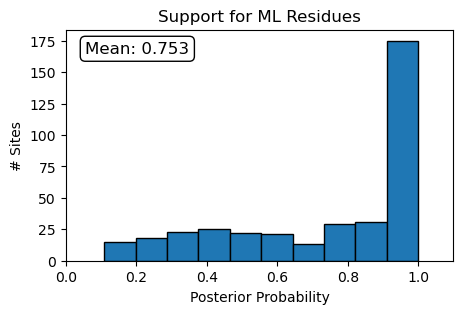

In [54]:
plot_max_support(probs_dict_no_gaps, "node233")

## Calculate identity between ancestors and native

In [55]:
def calc_identity(seq1, seq2):
    mafft_in = run_folder + "compare.fa"
    mafft_out = run_folder + "compare_mafft.fa"

    with open(mafft_in, "w") as file:
        file.write(">seq1" + "\n" + seq1 + "\n")
        file.write(">seq2" + "\n" + seq2 + "\n")

    mafft_cmd = f"mafft {mafft_in} > {mafft_out}"

    try:
        subprocess.run(mafft_cmd, shell=True, check=True, text=True, capture_output=True)
    except subprocess.CalledProcessError as e:
        print("Error occurred during alignment")
        print(e.stderr)

    aligned_sequences = [str(record.seq) for record in SeqIO.parse(mafft_out, "fasta")]
    aligned_pairs = [
        (a, b)
        for a, b in zip(aligned_sequences[0], aligned_sequences[1], strict=False)
        if a != "-" and b != "-"
    ]
    matches = sum(a == b for a, b in aligned_pairs)

    return (matches / len(aligned_pairs)) * 100

In [58]:
ancestor_of_interest = "node257"
extant_of_interest = "P00813_Homo_sapiens"

seq1 = [
    str(record.seq)
    for record in SeqIO.parse(ml_seqs_no_gaps, "fasta")
    if record.id == ancestor_of_interest
][0]
seq2 = [
    str(record.seq)
    for record in SeqIO.parse(input_sequences, "fasta")
    if record.id == extant_of_interest
][0]

print(
    f"{int(calc_identity(seq1, seq2))}% identity between "
    f"{ancestor_of_interest} and {extant_of_interest}"
)

98% identity between node257 and P00813_Homo_sapiens


## Visualize tree with ancestral nodes labeled (recommend FigTree for easier viewing)

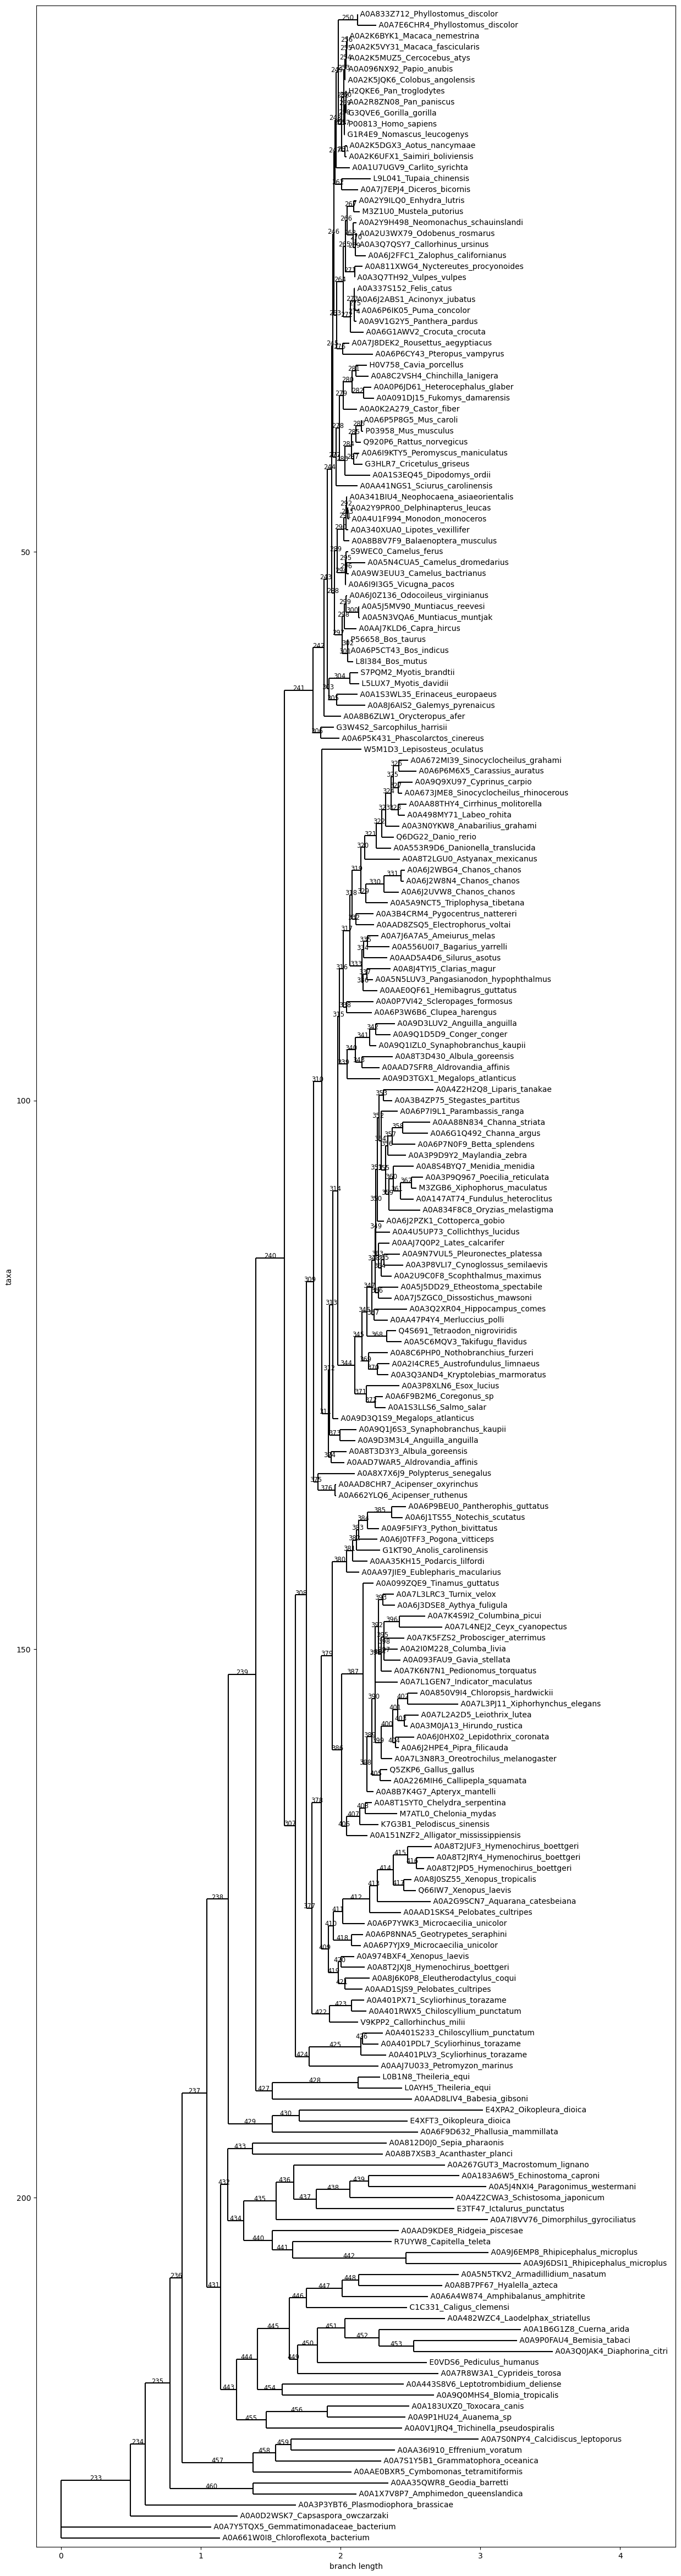

In [59]:
tree = Phylo.read(ancestor_tree, "newick")

fig = plt.figure(figsize=(15, 60))  # Adjust size (width, height)
ax = fig.add_subplot(1, 1, 1)


# Customize and render the tree
Phylo.draw(
    tree,
    axes=ax,
    label_colors={"orange": "orange"},  # Specify colors for labels
    do_show=False,  # Prevent automatic display
)

# Manually highlight nodes by drawing them in orange
for clade in tree.find_clades():
    if hasattr(clade, "color") and clade.color == "orange":
        ax.text(
            clade.branch_length,  # X-coordinate
            tree.depths()[clade],  # Y-coordinate
            clade.name,  # Node label
            color="orange",
            fontsize=8,
        )

# Show the plot
plt.show()